In [9]:
import geopandas as gpd
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.visualization import ee_viz
from src.data import mtbs
from src.data import shape_processor
from src.data import gedi_pipeline
from src.data import k_nn
import ee
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from fitter import Fitter, get_common_distributions, get_distributions
from src.processing.recent_fires import gedi_matching, matching_analysis
from src.visualization.gedi_viz import geo_plot
from src.data import pai_vertical
importlib.reload(gedi_matching)
importlib.reload(pai_vertical)

import importlib
importlib.reload(gedi_pipeline)
importlib.reload(gedi_matching)
importlib.reload(matching_analysis)
from src.data.gedi_pipeline import get_severity

2023-06-07 12:14:08,538 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


In [2]:
ee.Authenticate()


Successfully saved authorization token.


In [2]:
ee.Initialize()

In [3]:
sierras = gpd.read_file("../../../data/shapefiles/sierras_convex_hull.shp")
firep_db = FirePerimetersDB('../../../data/fire_perimeters.gdb/')
sierra_firep = FirePerimeters(firep_db).filter_for_years(['2021']).filter_within_geometry(sierras)

In [4]:
gedi_gdf= gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/sierras_matched_lc_all_2x2.csv')
gedi_burned, gedi_unburned = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_gdf)

2023-06-07 11:30:11,941 DEBUG: Excluded shots on the burn boundaries, shots remaining:         9446235 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-07 11:30:12,246 DEBUG: Number of GEDI shots that burned at least once:                  1440937 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-07 11:30:13,360 DEBUG: Number of GEDI shots that never burned since 1984:         7852535 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-07 11:30:13,686 DEBUG: Number of shots that burned exactly once:                    1253729 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-07 11:30:13,846 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    771977 [in exclude_shots_on_burn_b

In [5]:
gedi_l2b = gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/gedi_l2b_sierras_matched_lc_all_2x2.csv')
gedi_burned_l2b, gedi_unburned_l2b = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_l2b)

2023-06-07 11:32:51,306 DEBUG: Excluded shots on the burn boundaries, shots remaining:         14968077 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-07 11:32:51,824 DEBUG: Number of GEDI shots that burned at least once:                  2184975 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-07 11:32:54,139 DEBUG: Number of GEDI shots that never burned since 1984:         12539296 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-07 11:32:55,009 DEBUG: Number of shots that burned exactly once:                    1891695 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-07 11:32:55,355 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    1192212 [in exclude_shots_on_bur

In [6]:
fire = sierra_firep.get_fire('WINDY')

In [7]:
matches = gedi_matching.match_measurements_before_and_after_fire(fire, gedi_burned, 'agbd')

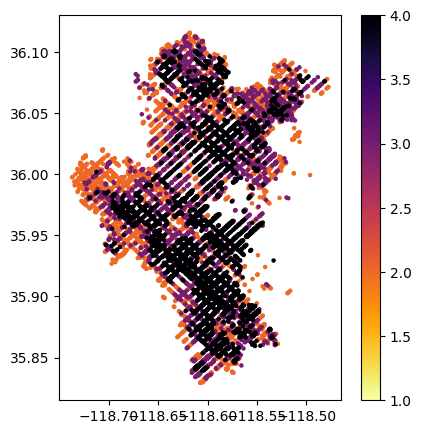

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
geo_plot(matches, ax, 'burn_severity_median', vmin=1, vmax=4)

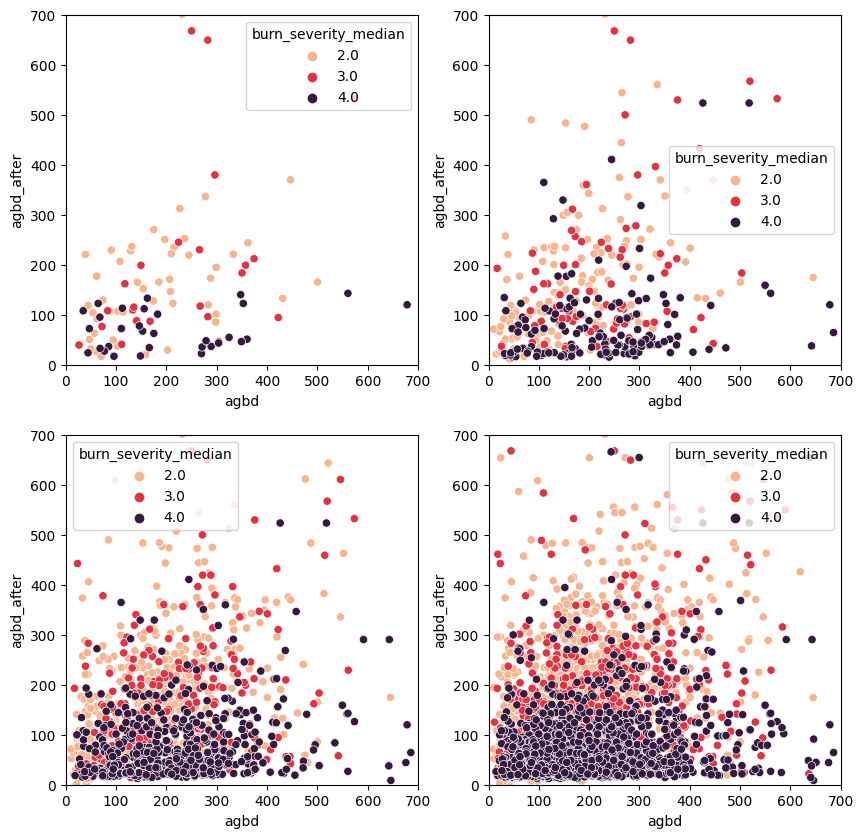

In [11]:
matching_analysis.plot_severity_for_distance(matches, 'agbd')

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


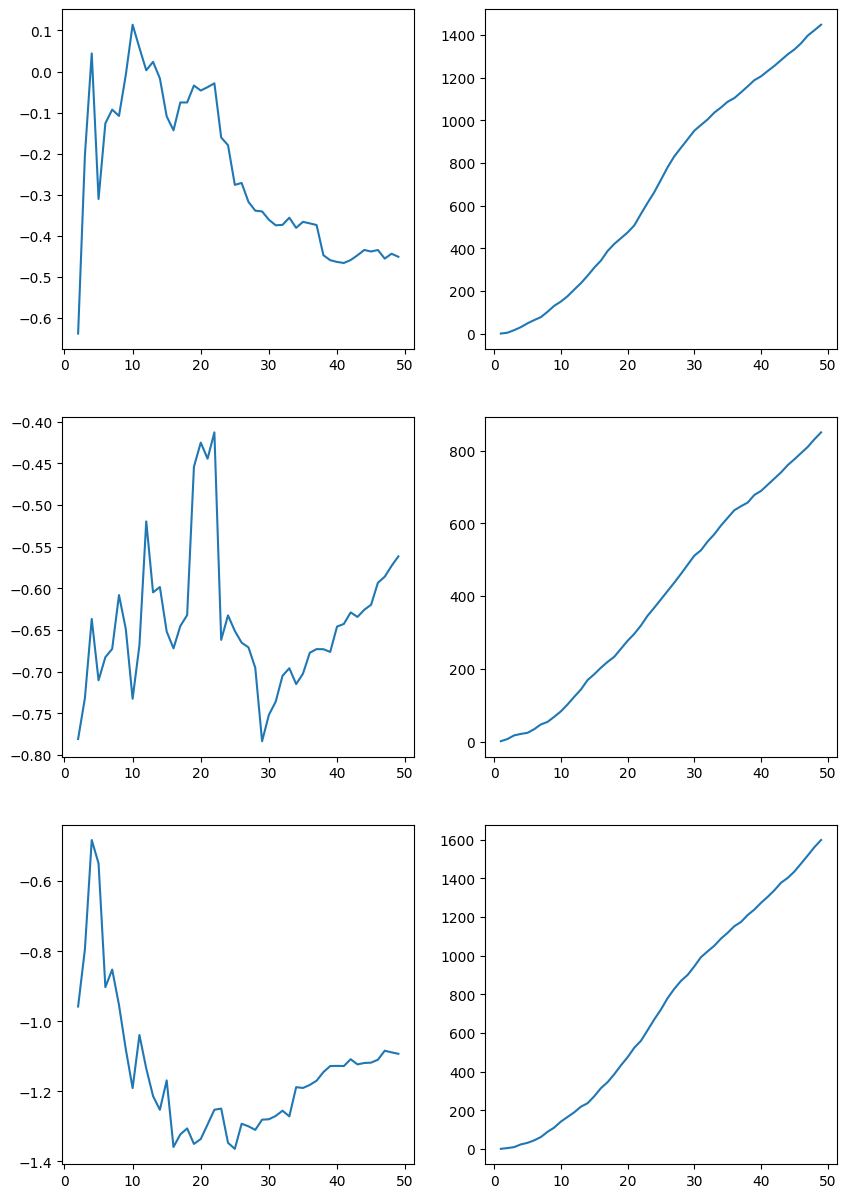

In [12]:
matching_analysis.plot_error_for_distances(matches, 'agbd')

In [13]:
def filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1) & (df.pft_class == 1)]

In [14]:
close_matches = filter_land_cover(matches[matches.closest_distance < 10])

Linear regression fit for severity 2.
Best Linear regression coefficient is [0.48873465].         R squared is : 0.2590068475903824.
The error for coeff = 1 is: 0.041848764451451914.
Linear regression fit for severity 3.
Best Linear regression coefficient is [0.29162991].         R squared is : 0.07414140210140929.
The error for coeff = 1 is: -0.7993970772626542.
Linear regression fit for severity 4.
Best Linear regression coefficient is [0.12287731].         R squared is : 0.03947606049639307.
The error for coeff = 1 is: -1.191755844108786.


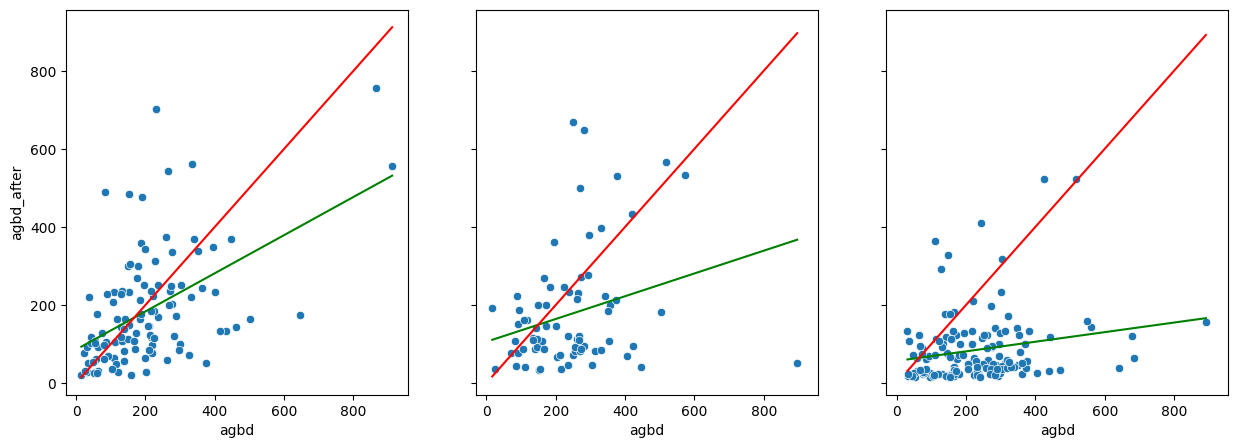

In [15]:
matching_analysis.fit_linear_regression_per_severity(close_matches, 'agbd')

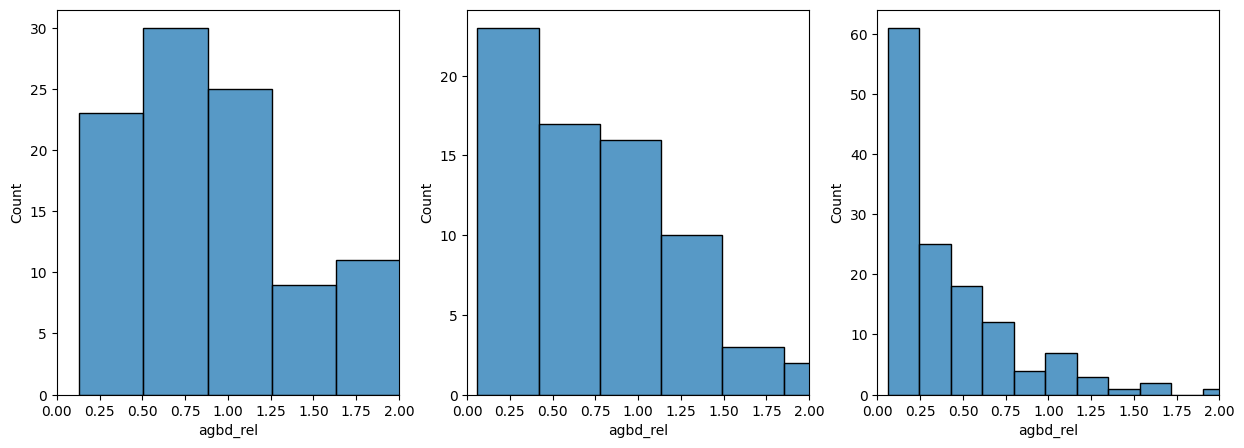

In [16]:
matching_analysis.plot_rel_difference_per_severity(close_matches, 'agbd')

### Fit distribution

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  6.35it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
norm            0.000096  1537.621461 -1554.854595     inf      0.087437   
beta            0.000097  1540.553317 -1545.139691     inf      0.087889   
gamma           0.000097  1539.029112 -1549.620412     inf      0.092372   
lognorm         0.000541  1789.987073 -1356.741951     inf      0.753317   
burr            0.000601  1748.737561 -1340.206244     inf      0.649880   

            ks_pvalue  
norm     3.388954e-01  
beta     3.329098e-01  
gamma    2.774123e-01  
lognorm  2.066888e-66  
burr     9.729802e-47  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 32.92it/s]


{'norm': {'loc': 17.172641575336456, 'scale': 144.1953898497506}}


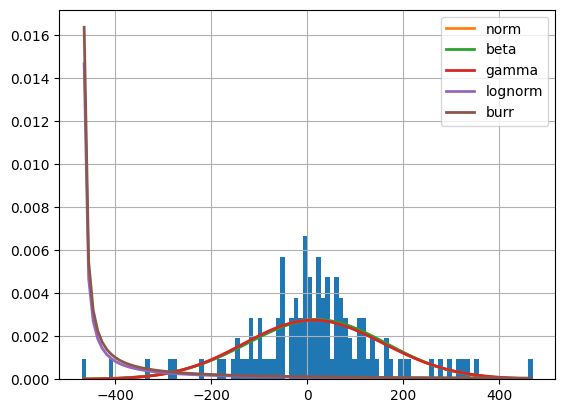

In [17]:
matching_analysis.fit_distributions(get_severity(close_matches, 2), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
lognorm         0.000080  1695.854872 -1018.792231     inf      0.107268   
gamma           0.000080  1699.187481 -1018.714364     inf      0.107286   
beta            0.000080  1697.568022 -1014.162461     inf      0.109095   
norm            0.000080  1741.012357 -1022.499781     inf      0.116594   
burr            0.000377  1807.035098  -897.767772     inf      0.642522   

            ks_pvalue  
lognorm  3.301759e-01  
gamma    3.299870e-01  
beta     3.109798e-01  
norm     2.403513e-01  
burr     1.127508e-30  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 30.92it/s]


{'norm': {'loc': 66.51204701741537, 'scale': 171.37770323586057}}


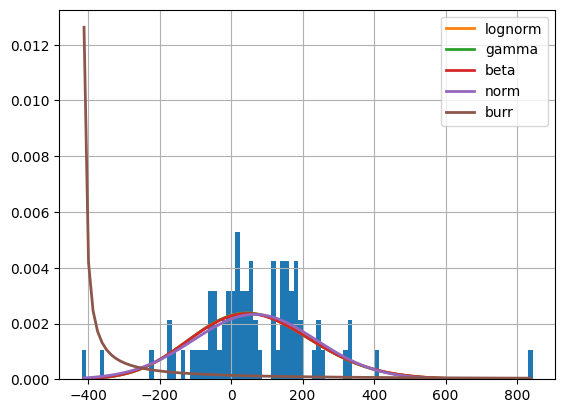

In [18]:
matching_analysis.fit_distributions(get_severity(close_matches, 3), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
lognorm         0.000064  1558.527841 -2012.669308     inf      0.058169   
gamma           0.000065  1560.556269 -2012.251390     inf      0.059625   
beta            0.000065  1561.248555 -2007.220035     inf      0.060031   
norm            0.000067  1584.383945 -2012.962735     inf      0.066311   
burr            0.000531  1732.472897 -1714.314778     inf      0.583341   

            ks_pvalue  
lognorm  7.123293e-01  
gamma    6.835626e-01  
beta     6.754991e-01  
norm     5.515198e-01  
burr     1.794688e-45  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 33.45it/s]


{'norm': {'loc': 146.4907838835133, 'scale': 152.05681232298446}}


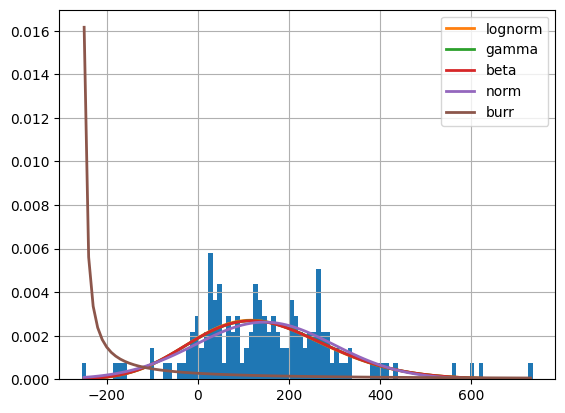

In [19]:
matching_analysis.fit_distributions(get_severity(close_matches, 4), 'agbd')

### Stat tests

In [20]:
matching_analysis.two_sided_tests(get_severity(close_matches, 2), 'agbd')

Shapiro test results ShapiroResult(statistic=0.959598183631897, pvalue=0.001860081567429006)
Ttest results: TtestResult(statistic=1.2547211519599177, pvalue=0.21221548049743041, df=111)
Wilcoxon test results: WilcoxonResult(statistic=2634.0, pvalue=0.12388789820825392)


In [21]:
matching_analysis.two_sided_tests(get_severity(close_matches, 3), 'agbd')

Shapiro test results ShapiroResult(statistic=0.9204235672950745, pvalue=0.0001645166048547253)
Ttest results: TtestResult(statistic=3.338580526039609, pvalue=0.00132068904576883, df=74)
Wilcoxon test results: WilcoxonResult(statistic=753.0, pvalue=0.0003873817220258483)


In [22]:
matching_analysis.two_sided_tests(get_severity(close_matches, 4), 'agbd')

Shapiro test results ShapiroResult(statistic=0.9617618322372437, pvalue=0.0006330960895866156)
Ttest results: TtestResult(statistic=11.317329602600406, pvalue=2.0525305046681948e-21, df=138)
Wilcoxon test results: WilcoxonResult(statistic=650.0, pvalue=7.862132447973614e-19)


## PAI Analysis

In [23]:
matches_l2b = gedi_matching.match_measurements_before_and_after_fire(fire, gedi_burned_l2b, 'pai')

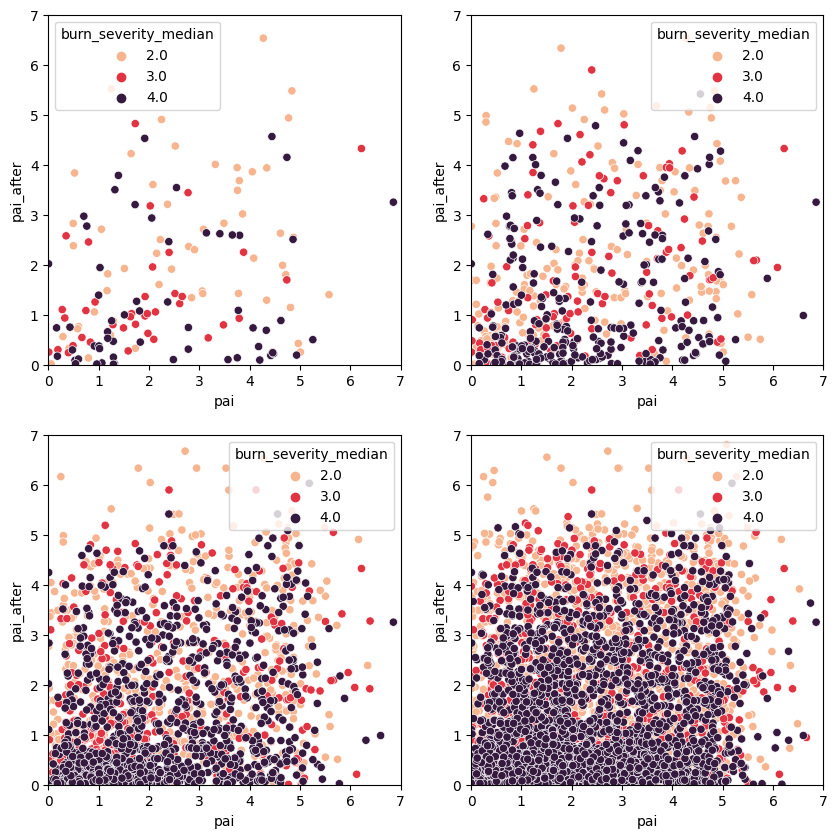

In [24]:
matching_analysis.plot_severity_for_distance(matches_l2b, 'pai', 7)

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


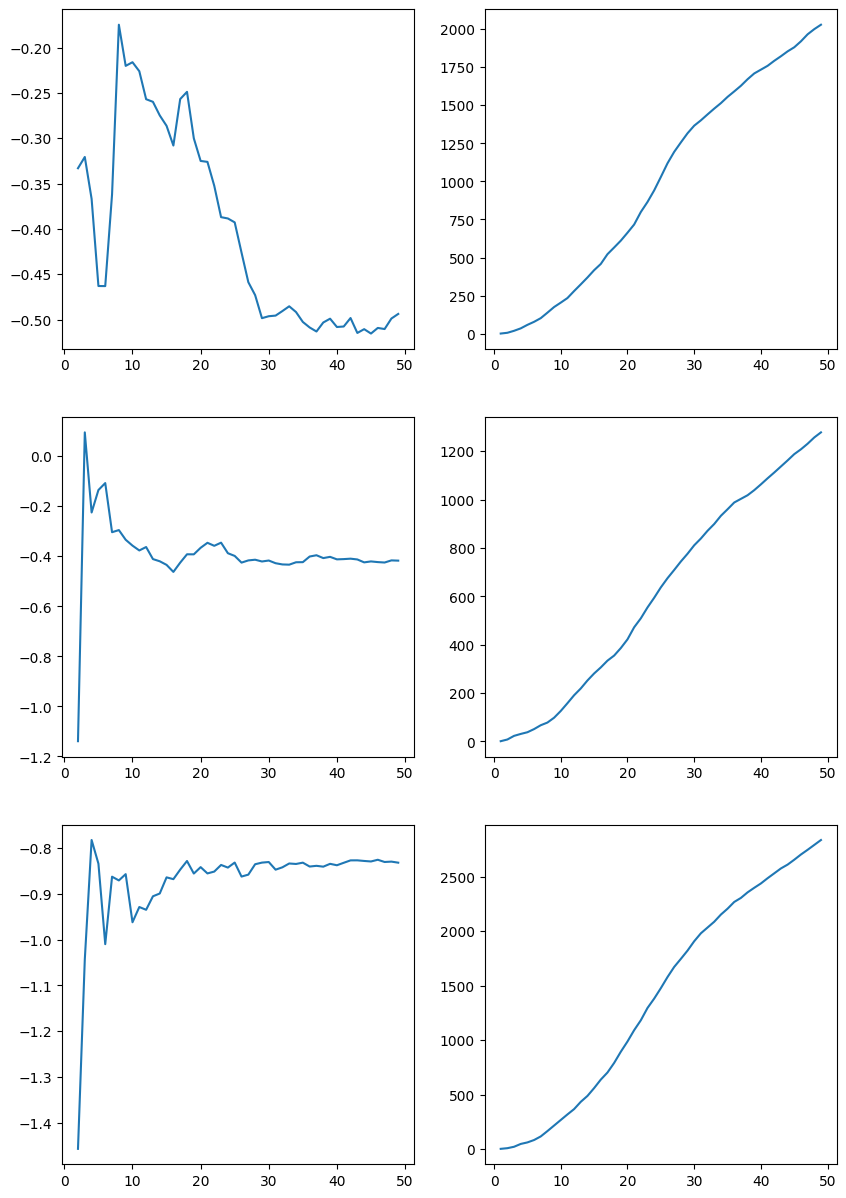

In [25]:
matching_analysis.plot_error_for_distances(matches_l2b, 'pai')

## PAI Z Analysis

In [26]:
matches_paiz = gedi_matching.match_pai_z_before_and_after_fire(fire, gedi_burned_l2b)

In [27]:
def l2b_filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1)]

close_matches = l2b_filter_land_cover(matches_paiz[matches_paiz.closest_distance < 20])
close_matches['date_since'] = ((close_matches.match_datetime - fire.cont_date)/np.timedelta64(1, 'M')).astype(int)

In [28]:
unpacked = matching_analysis.transform_pai_z_data(close_matches)

(0.0, 13.0)

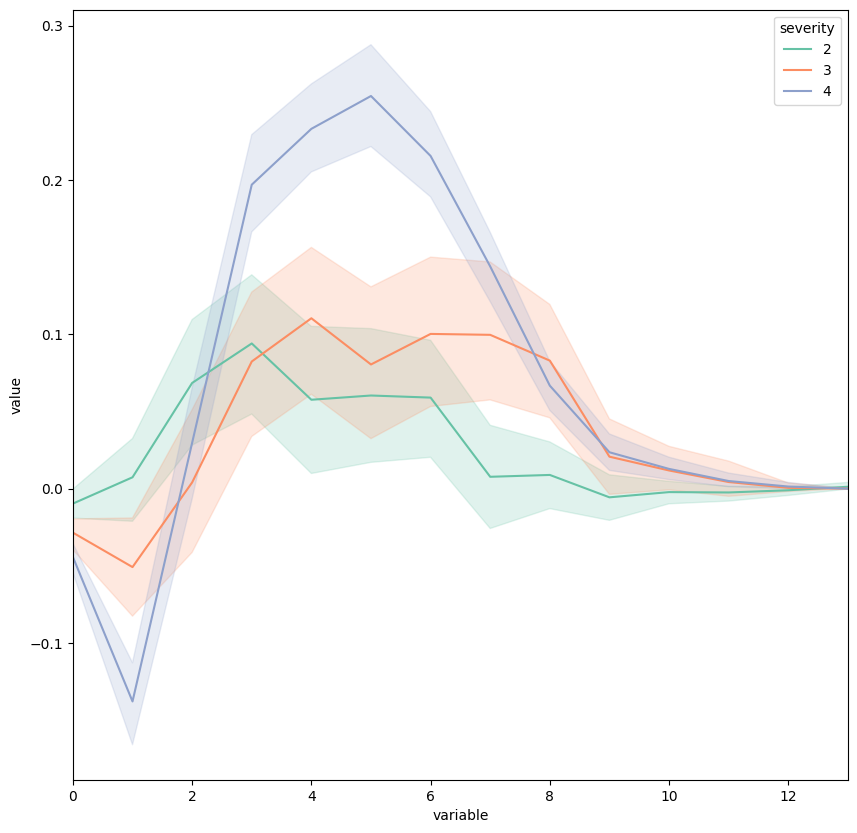

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(unpacked, x='variable', y='value', hue='severity', ax=ax, palette='Set2')
ax.set_xlim((0, 13))

(0.0, 13.0)

<Figure size 2000x500 with 0 Axes>

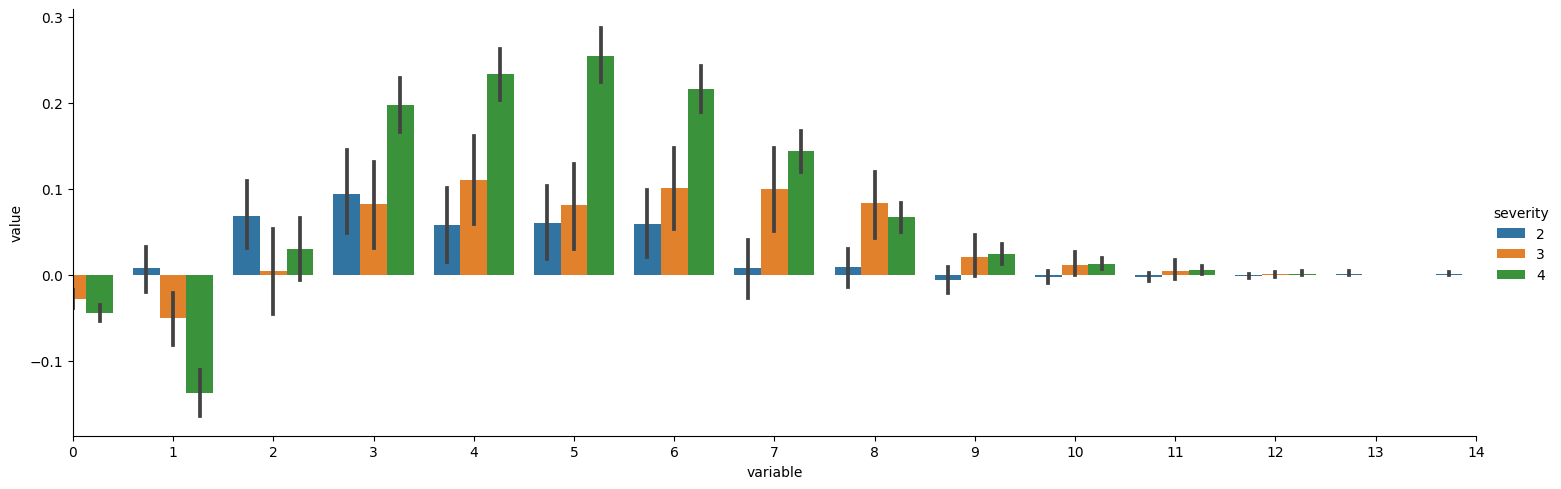

In [30]:
plt.figure(figsize=(20,5))
g = sns.catplot(unpacked, x='variable', y='value', hue='severity', kind='bar', height=5, aspect=3)
g.set(xlim=(0,14))
ax.set_xlim((0, 13))

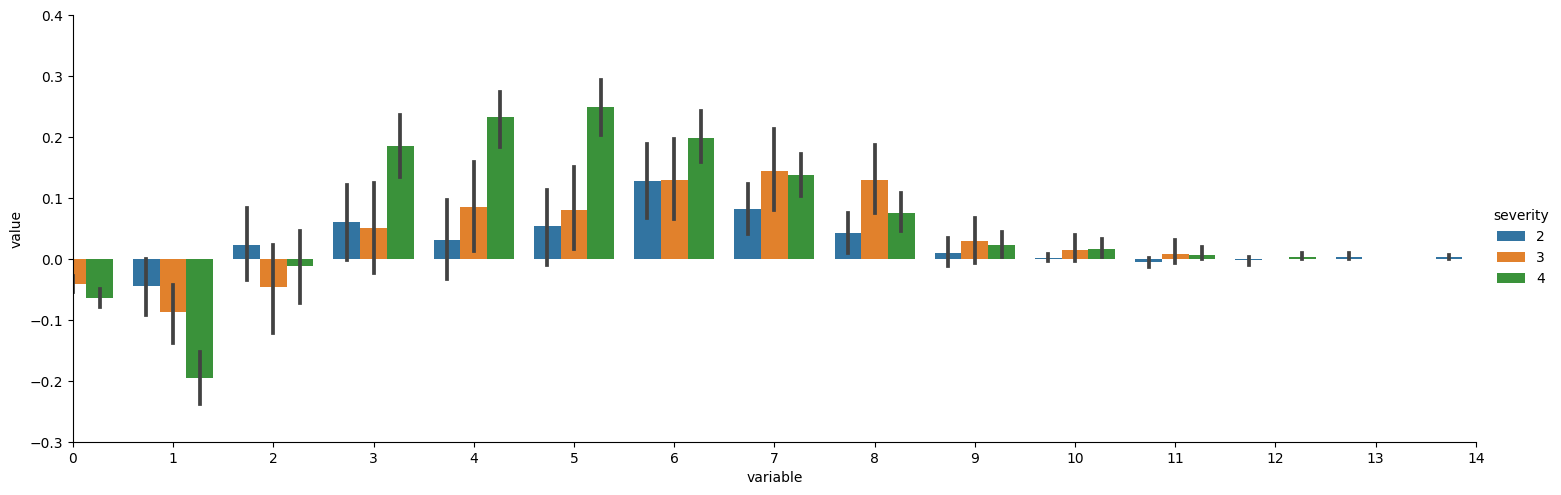

In [31]:
g = sns.catplot(unpacked[unpacked.date_since < 6], x='variable', y='value', hue='severity', kind='bar', height=5, aspect=3)
g.set(xlim=(0,14))
g.set(ylim=(-0.3, 0.4))

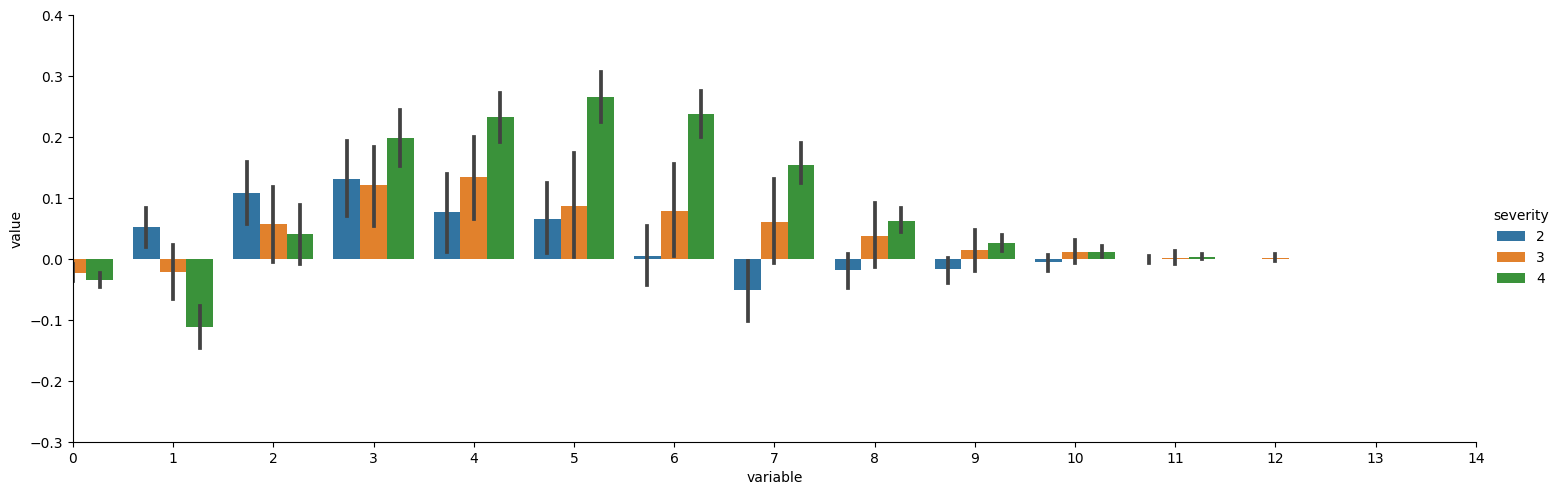

In [32]:
g = sns.catplot(unpacked[unpacked.date_since > 6], x='variable', y='value', hue='severity', kind='bar', height=5, aspect=3)
g.set(xlim=(0,14))
g.set(ylim=(-0.3, 0.4))

In [33]:
unpacked_granular = gedi_matching.add_date_since_burn_categories_granular(unpacked.reset_index())
unpacked_coarse = gedi_matching.add_date_since_burn_categories_coarse(unpacked.reset_index())

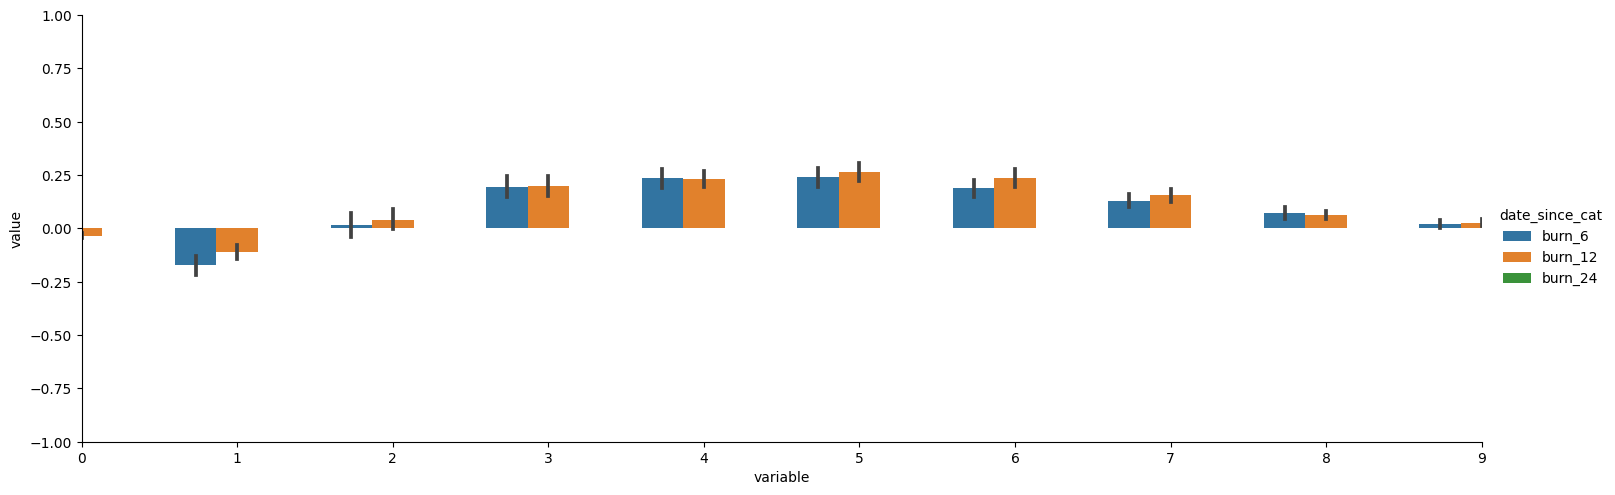

In [34]:
g = sns.catplot(unpacked_coarse[unpacked_coarse.severity==4], x='variable', y='value', hue='date_since_cat', kind='bar', height=5, aspect=3)
g.set(xlim=(0,9))
g.set(ylim=(-1,1))

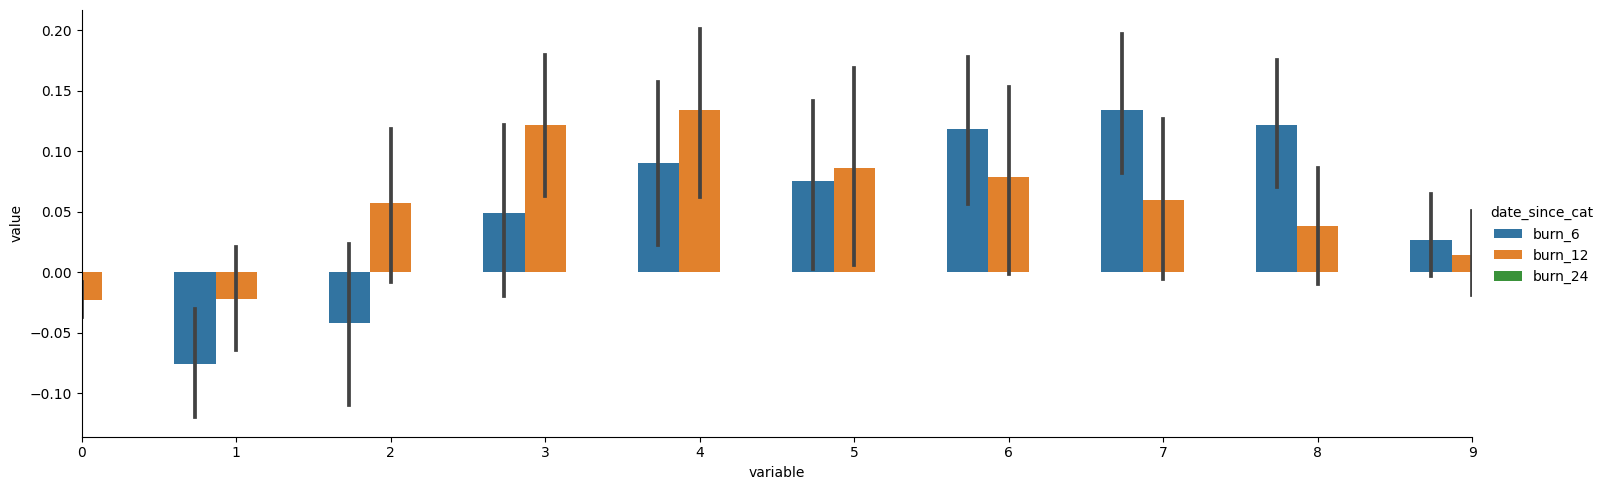

In [35]:
g = sns.catplot(unpacked_coarse[unpacked_coarse.severity==3], x='variable', y='value', hue='date_since_cat', kind='bar', height=5, aspect=3)
g.set(xlim=(0,9))
#g.set(ylim=(-1,1))

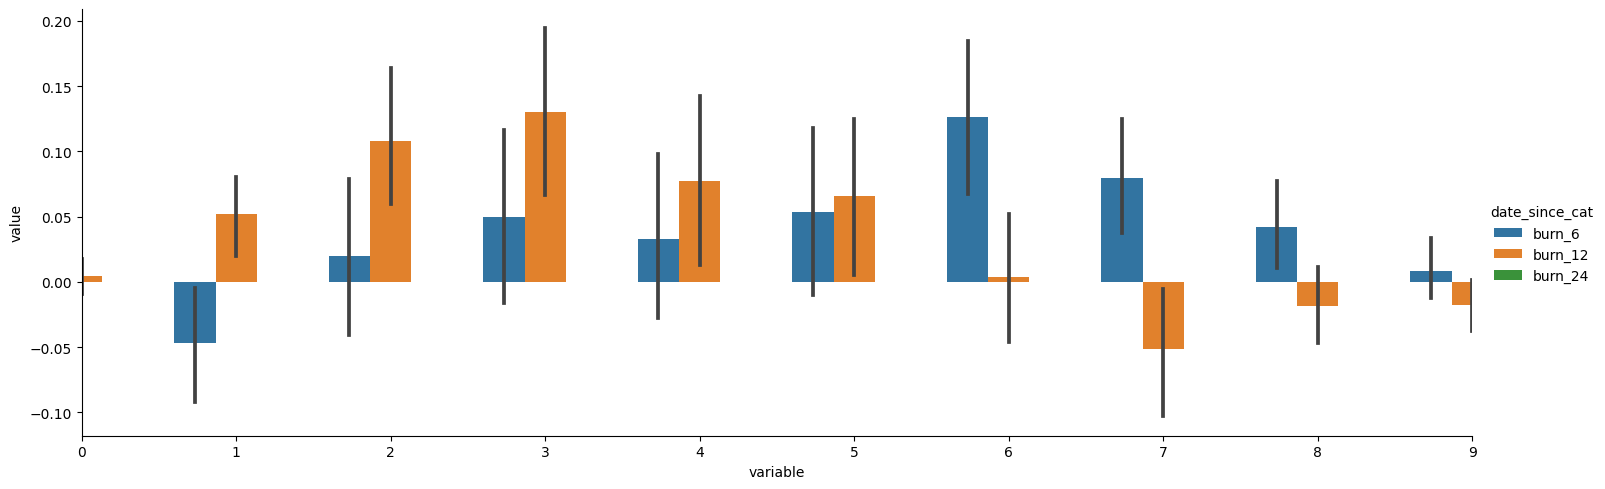

In [36]:
g = sns.catplot(unpacked_coarse[unpacked_coarse.severity==2], x='variable', y='value', hue='date_since_cat', kind='bar', height=5, aspect=3)
g.set(xlim=(0,9))
#g.set(ylim=(-1,1))

<Axes: xlabel='date_since_cat', ylabel='value'>

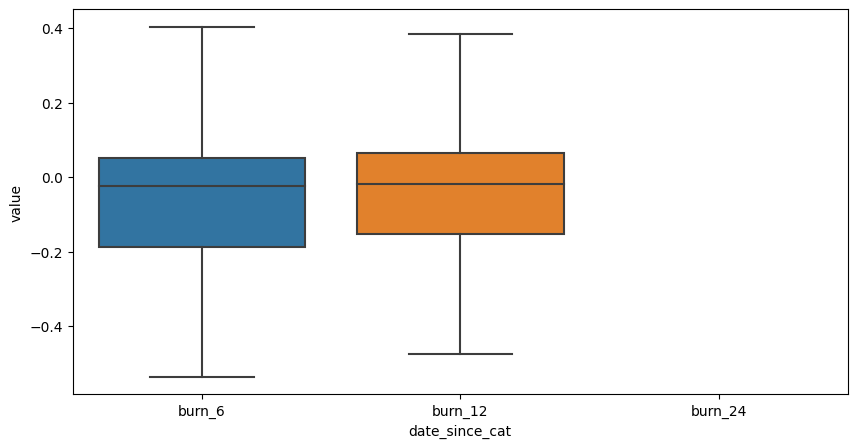

In [46]:
plt.figure(figsize=(10,5))
lala = unpacked_coarse[(unpacked_coarse.severity==4) & (unpacked_coarse.variable < 2)]
sns.boxplot(lala, x='date_since_cat', y='value', showfliers=False)